# Cтратегия взаимодействия с клиентами и их удержания

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

Цель: удержать клиентов сети фитнес-центров «Культурист-датасаентист»

Задача: провести анализ и подготовить план действий по удержанию клиентов. А именно:
-научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
-сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
-проанализировать основные признаки, наиболее сильно влияющие на отток;
-сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами.

## Загрузка и проверка данных

In [1]:
# загрузка нужных библиотек
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# для полного отображения содержимого столбцов
pd.set_option('display.max_colwidth', -1)
# импорт sklearn и ее методов/алгоритмов
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# читаем файл,присваиваем ему переменную
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# посмотрим размер датафрейма
data.shape

(4000, 14)

In [4]:
# переведем название столбцов в нижний регистр для удобства
data.columns = data.columns.str.lower()

In [5]:
# посмотрим общуб информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [6]:
# посмотрим дубликаты
data.duplicated().sum()

0

Исходные данные хорошие, без пропусков, дубликатов нет, тип данных соответствует столбцам. Все готово к дальнейшему анализу

## Исследовательский анализ данных (EDA)

Изучаем средние значения и стандартные отклонения 

In [7]:
data.describe().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.0,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.0,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Мужчин и женщин в фитнес клубе поровну, более 84% проживают рядом, почти половиина участиники партнерской программы, более 30% купил абонемент по программе "Приведи друга", 90% оставляют свой номер телефона, в среднем текущмй абонемет длиться 4 месяца(покупают в основном на полгода), более 41% посещают групповые занятия,и средний возраст 29 лет и надо отметить, что 75% моложе 31 года, максимальный возраст 41 год, среднее количество месяцев посещения почти 4,в среднем дополнительные покупки делают на 146 у.е,среднее количество посещений в неделю за все время практически совпадает с количеством за текущий месяц и составляет около 2 посещений в неделю, средний отток составляет 27 %

Находим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
churn_group = data.groupby('churn').mean().round(2)
churn_group = churn_group.transpose()
churn_group

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Те, кто остался в основном рядом живет, любого пола,в возрасте почти 30 лет, участвующий партнерской программе или в акции "Приведи друга", посещает фитнес около полугода и абонемент действует еще полгода, посещает фитнес 2 раза в неделю

Строим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

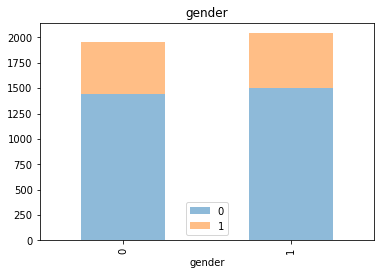

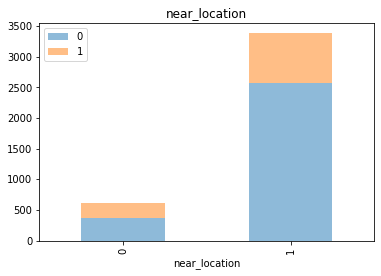

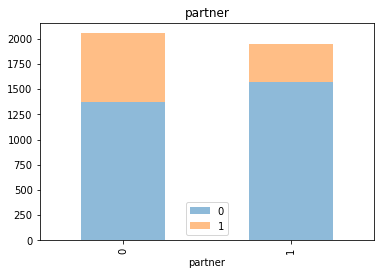

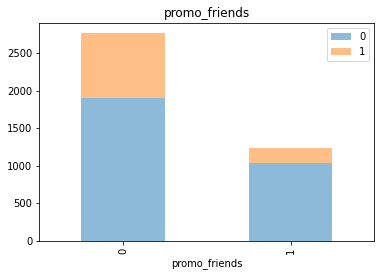

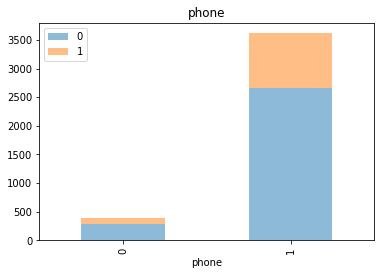

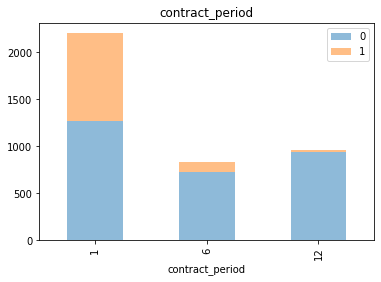

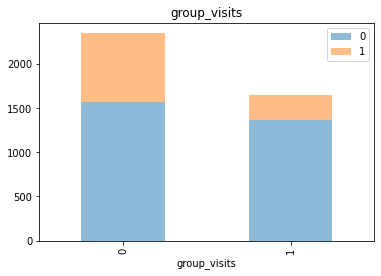

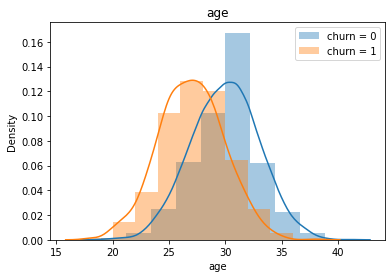

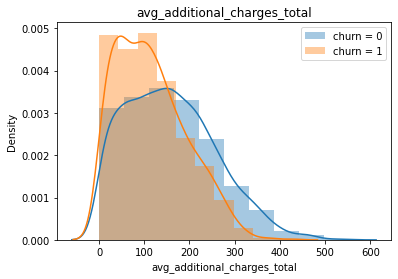

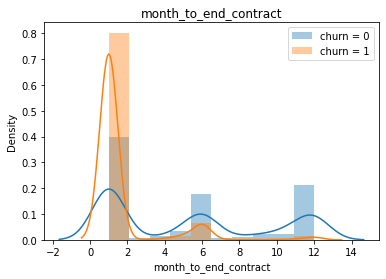

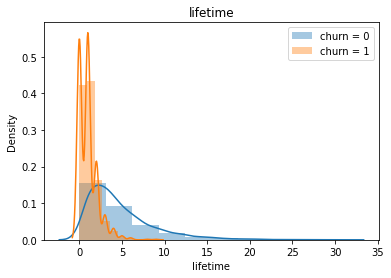

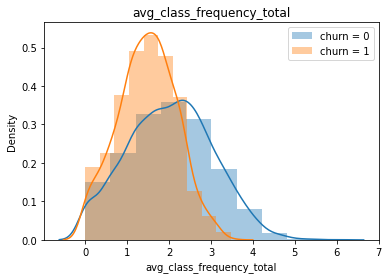

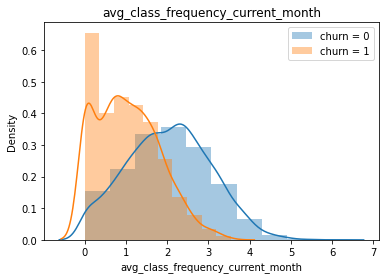

In [9]:
def feat_hist(x, group_col, key_cols):
    x_new = x.copy()[key_cols]
    for c in key_cols:
 
        if c == group_col: continue
 
        if len(x_new[c].unique()) < 10:
            report = x_new.reset_index().pivot_table(index=c, columns=group_col, values='index', aggfunc='count')
            report.plot(kind='bar', stacked=True, alpha=0.5)
 
        else:
            for c1 in x[group_col].unique():
                sns.distplot(x_new[x_new[group_col] == c1][c],
                             label = '{} = {}'.format(group_col, str(c1)), bins=10)
 
        plt.title(c)
        plt.legend()
        plt.show()
 
feat_hist(data, 'churn', data.columns)

Постройте матрицу корреляций и отобразите её

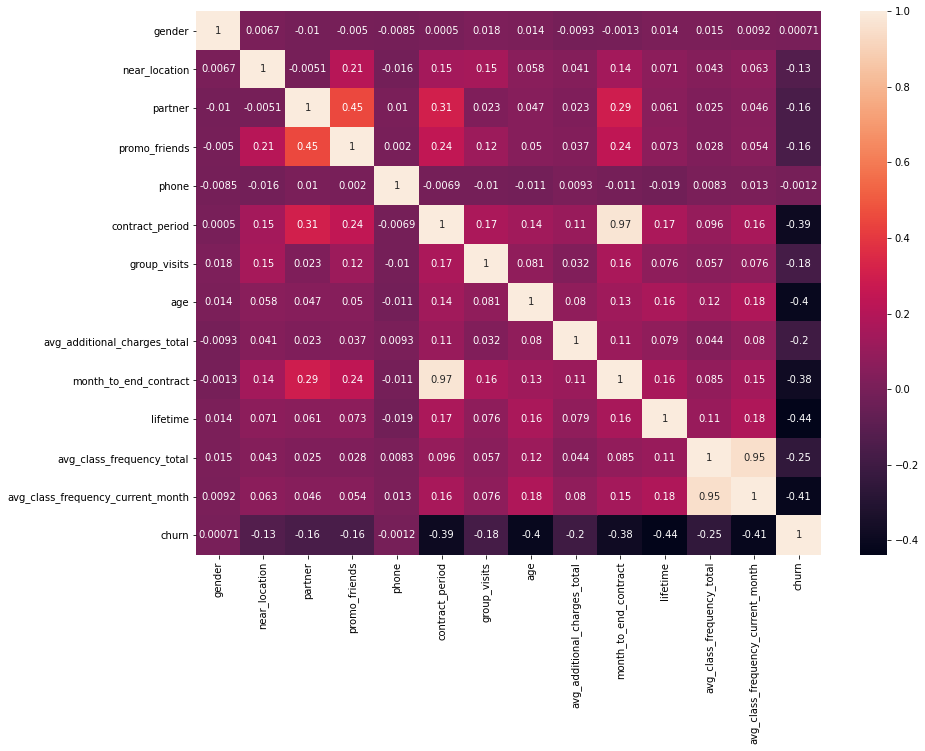

In [10]:
corr = data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot = True)
plt.show()

признаки: month_to_end_contract и contract_period, а также avg_class_frequency_total и avg_class_frequency_current_month очень сильно коррелируют, так как являются очень близкими показателями, по одному признаку из пары стоит удалить перед обучением.

Удаляем month_to_end_contract и avg_class_frequency_current_month

In [11]:
data = data.drop(columns = ['month_to_end_contract','avg_class_frequency_current_month'])

Строим матрицу без них

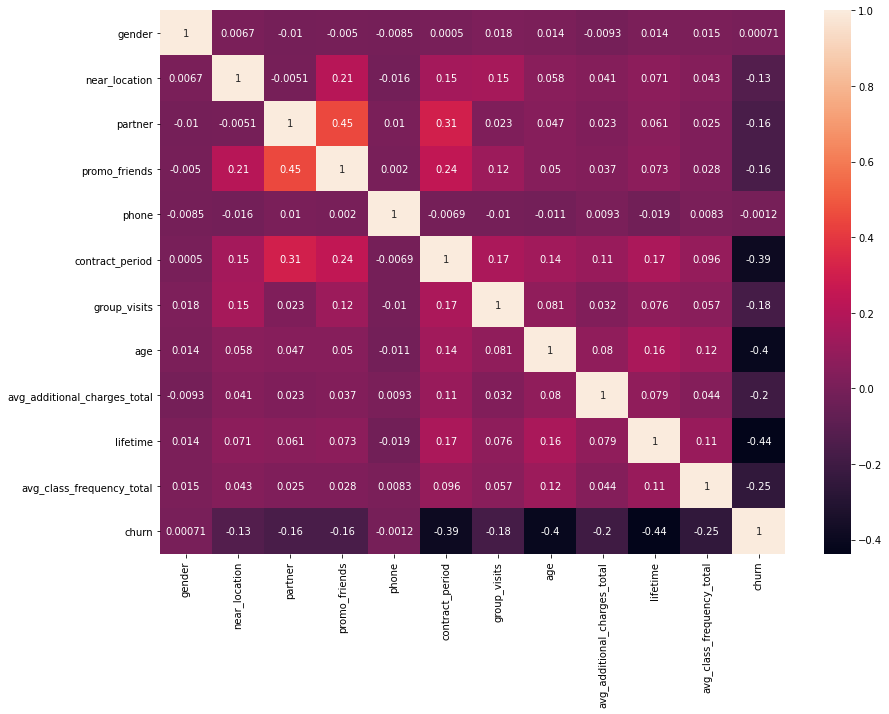

In [12]:
corr = data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot = True)
plt.show()

Чем больше клиентов участвующих в партнерской компании и ближе к дому клуб, тем выше показатель "приведи друга". Также количество партнеров, близость к дому и наличие друзей положительно влияют на длительность действующего абонемента.

Отток снижается, если клиенты живут недалеко от фитнеса, более старшего возраста,в районе где-то 30 лет, участвуют в программе "приведи друга" или партнерской программе, ходит часто и покупает на доп.услуги, посещает групповые занятия.

## Построение модели прогнозирования оттока клиентов

Строим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

Разбиваем данные на обучающую и валидационную выборку функцией train_test_split()

In [13]:
X = data.drop('churn', axis = 1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Обучаем модель на train-выборке логистической регрессией

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [15]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [16]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.87
Precision: 0.73
Recall: 0.77
F1: 0.75


Обучаем модель на train-выборке случайным лесом

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [18]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.89
Precision: 0.79
Recall: 0.76
F1: 0.77


По показателям видим, что логистическая регрессия выглядит лучше

## Кластеризация клиентов

Удаляем столбец с оттоком для проведения кластеризации объектов (клиентов).
Стандартизируем данные

In [19]:
data_cl = data.drop(['churn'], axis=1)
data_columns_list = data_cl.columns
data_cl = StandardScaler().fit_transform(data_cl)
data_cl = pd.DataFrame(data_cl, columns = data_columns_list).astype('float64')

Строим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и рисуем дендрограмму. 

In [20]:
linked = linkage(data_cl, method = 'ward')

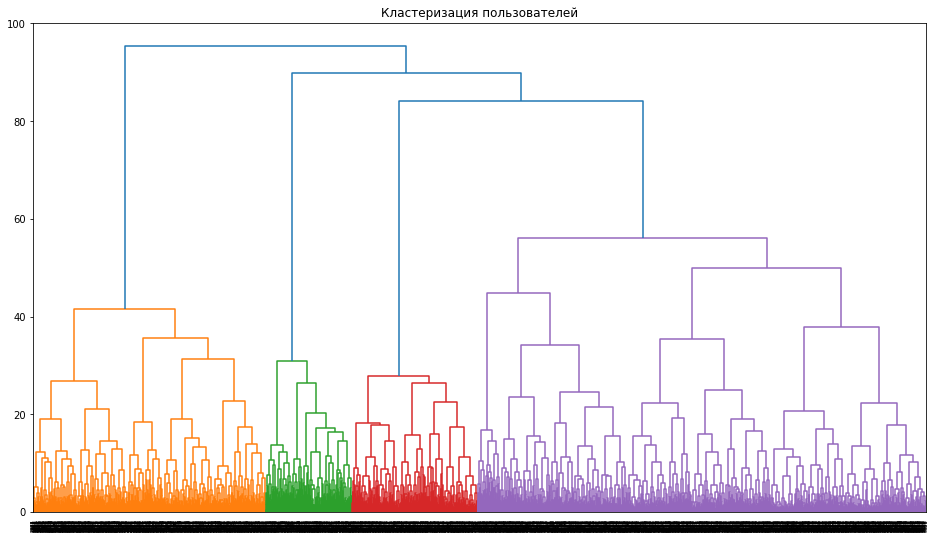

In [21]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Обучаем модель кластеризации на основании алгоритма K-Means и прогнозируем кластеры клиентов. 

In [22]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(data_cl)
data['cluster'] = labels

In [23]:
data.cluster.value_counts()

2    1132
1    1050
3    871 
0    561 
4    386 
Name: cluster, dtype: int64

Считаем средние значения признаков для кластеров

In [24]:
data.groupby('cluster').mean().T.round(2)

cluster,0,1,2,3,4
gender,0.50,0.49,0.51,0.54,0.52
near_location,0.00,1.00,1.00,1.00,0.86
partner,0.49,0.96,0.24,0.25,0.47
promo_friends,0.08,0.89,0.06,0.08,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,3.03,7.66,2.82,4.53,4.78
group_visits,0.24,0.46,0.00,1.00,0.43
age,28.72,29.54,28.77,29.54,29.30
avg_additional_charges_total,137.54,155.86,143.38,148.09,144.21
lifetime,3.06,4.38,3.34,3.76,3.94


Строим распределения признаков для кластеров

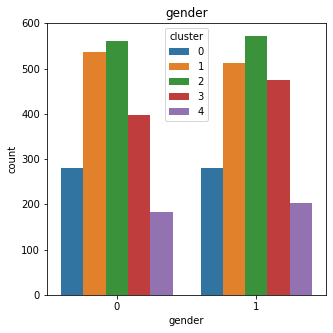

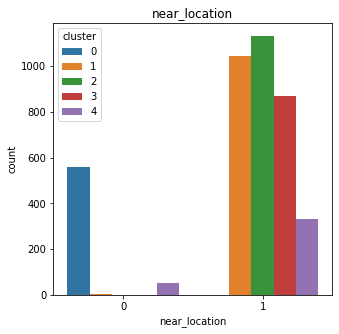

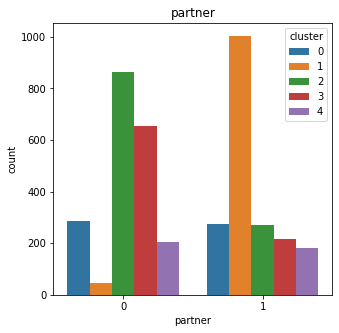

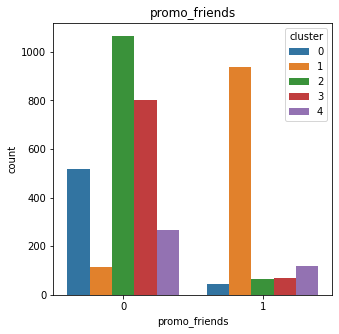

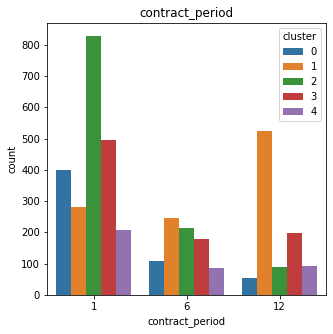

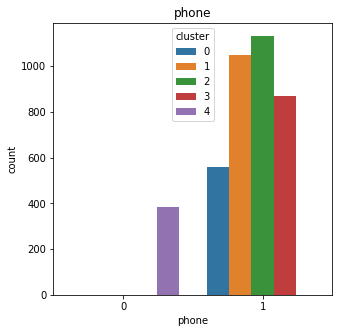

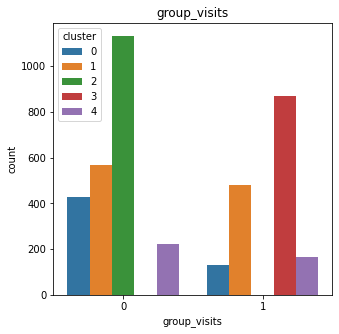

In [25]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period','phone','group_visits']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = data[column], hue='cluster', data=data)
    plt.title(column)
    plt.show()

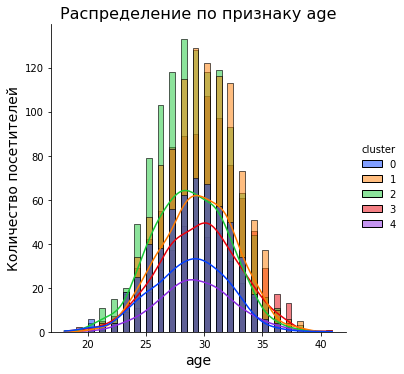

<Figure size 1296x360 with 0 Axes>

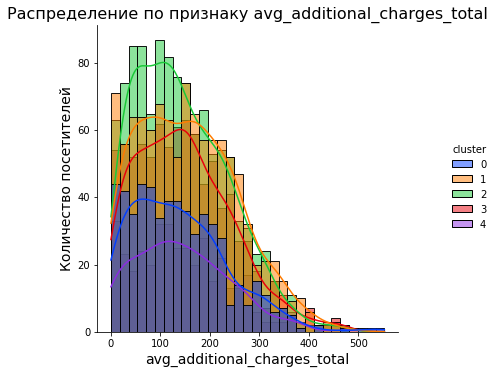

<Figure size 1296x360 with 0 Axes>

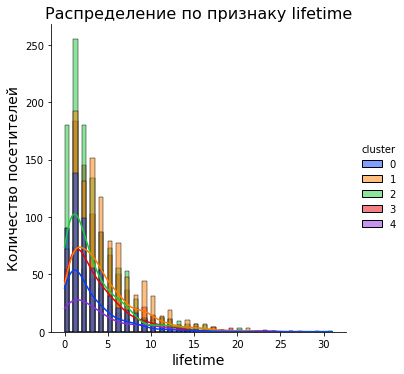

<Figure size 1296x360 with 0 Axes>

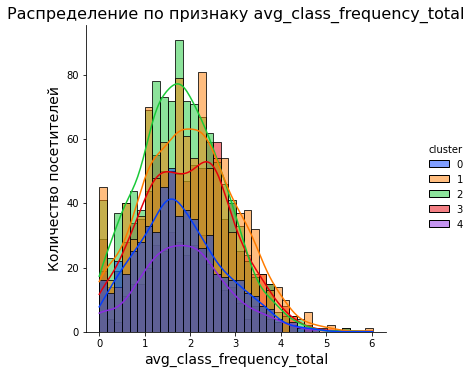

<Figure size 1296x360 with 0 Axes>

In [26]:
for name in [
   'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']:
    
 
    sns.displot(data = data, x = name, kde=True, hue = 'cluster',palette = 'bright')
    plt.title('Распределение по признаку '  +name, fontsize = 16, color = 'black')
    plt.ylabel('Количество посетителей', fontsize = 14, color = 'black')
    plt.xlabel(name, fontsize = 14, color = 'black')
    plt.figure(figsize=(18,5))
plt.show()

Кластеры склонные к оттоку - 1 и 3. Клиенты кластера 1 живут далеко от фитнеса, меньше других покупают доп.услуги. Вместе с клиентами кластера 3 они посещают фитнес примерно раз в неделю, почти не ходят на групповые занятия,в основном не участники акции "Приведи друга", посещают клуб не больше 3 месяцев, возраст клиентов 28 лет.

Надежные кластеры 2,4,5. Самый надежный 2. Клиенты данного кластера живут рядом с фитнесом, уаствуют в партнерской программе, и в акции "Приведи друга",тратят больше всех на доп. услуги, ходят 2 раза в неделю, постоянные клиенты с "длинным" абонементом .

## Выводы и рекомендации

В ходе проведенного анализа сформировались рекомендации:
* Поддерживать и мотивировать надежные кластеры для их дальнейшего удержания, например, скидкой на продление абонемента
-Привлечение новых клиентов по акции "приведи друга"
-Расширение программы привлечения сотрудников компаний-партнеров и списка самих партнеров
-Активная реклама клуба в районе его расположения
-Повышение вовлеченности на групповых занятиях 
-Предлагать индивидуальные предложения для определенных групп клиенто
-Проводить регулярно анализ и смотреть показатели, чтобы предотвратить отток клиентов